In [1]:
import numpy as np
import pandas as pd
import pycharles
import random
#import tensorflow as tf
#import keras
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from dython import nominal
from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.callbacks import EarlyStopping
#from keras.initializers import RandomNormal
#from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sympy.plotting import plot_implicit
from sympy.parsing.sympy_parser import parse_expr
from ipywidgets import interact

SEED = 42
random.seed(SEED)

/Users/shakedzy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/shakedzy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Preparing the data

In [2]:
data = pd.read_csv('train.csv').drop(['Cabin','Ticket','PassengerId'],axis=1)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [3]:
def name_title(name):
    title = name.split(',')[1].split('.')[0].strip()
    titles_dict =   {'Capt': 'Military',
                     'Col': 'Military',
                     'Don': 'Royalty',
                     'Dr': 'Dr',
                     'Jonkheer': 'Royalty',
                     'Lady': 'Royalty',
                     'Major': 'Military',
                     'Master': 'Master',
                     'Miss': 'Miss',
                     'Mlle': 'Miss',
                     'Mme': 'Ms',
                     'Mr': 'Mr',
                     'Mrs': 'Mrs',
                     'Ms': 'Ms',
                     'Rev': 'Rev',
                     'Sir': 'Royalty',
                     'the Countess': 'Royalty'}
    return titles_dict[title]
    
data.loc[:,'Title'] = data.apply(lambda row: name_title(row['Name']),axis=1)
data.drop(['Name'],axis=1,inplace=True)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [4]:
titles = Counter(data['Title'])
titles

Counter({'Dr': 7,
         'Master': 40,
         'Military': 5,
         'Miss': 184,
         'Mr': 517,
         'Mrs': 125,
         'Ms': 2,
         'Rev': 6,
         'Royalty': 5})

In [5]:
avg_age = dict()
for title in titles.keys():
    df = data[data['Title'].isin([title])].dropna(subset=['Age'])
    avg_age[title] = df['Age'].sum()/len(df.index)
avg_age

{'Dr': 42.0,
 'Master': 4.574166666666667,
 'Military': 56.6,
 'Miss': 21.804054054054053,
 'Mr': 32.368090452261306,
 'Mrs': 35.898148148148145,
 'Ms': 26.0,
 'Rev': 43.166666666666664,
 'Royalty': 41.6}

In [6]:
def fix_age(row):
    if np.isnan(row['Age']):
        return avg_age[row['Title']]
    else:
        return row['Age']
    
def fix_port(row):
    if pd.isnull(row)['Embarked']:
        return '?'
    else:
        return row['Embarked']
    
data.loc[:,'Age'] = data.apply(lambda row: fix_age(row),axis=1)
data.loc[:,'Embarked'] = data.apply(lambda row: fix_port(row),axis=1)

In [7]:
nn_data = nominal.numerical_encoding(data,nominal_columns=['Sex','Embarked','Title'])
X = nn_data.drop(['Survived'],axis=1)
y = nn_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
y_train_cat = to_categorical(y_train,2)
y_test_cat = to_categorical(y_test,2)
X_train.shape

(623, 19)

## Learning the solution space
To properly evaluate the Genetic Model efficency, I've calculated the AUC of all 1050 (!!) neural networks int he solution space, using the commented-out function. It took my MacBook Pro 18 hours to complete that, so I saved as a file, which will be loaded to a dictionary contaning all possible solutions which can be selected at random (`rand_dict`). You can try recalculate everything yourself, though note that the output will be a little different due to the randomness of Keras.

### AUC calculation:
`auc_score` is an important function: it gets an array of two numbers, which represent the number of nodes in the first and second layers. It then constructs a neural network with that architecture, trains it and calculates its AUC score. (Now it just loads the pre-calculated value from `rand_dict`, where each key looks like this `f|s`, where `f` is the number of nodes in the first hidden layer and `s` is the number of nodes in the second hidden layer)

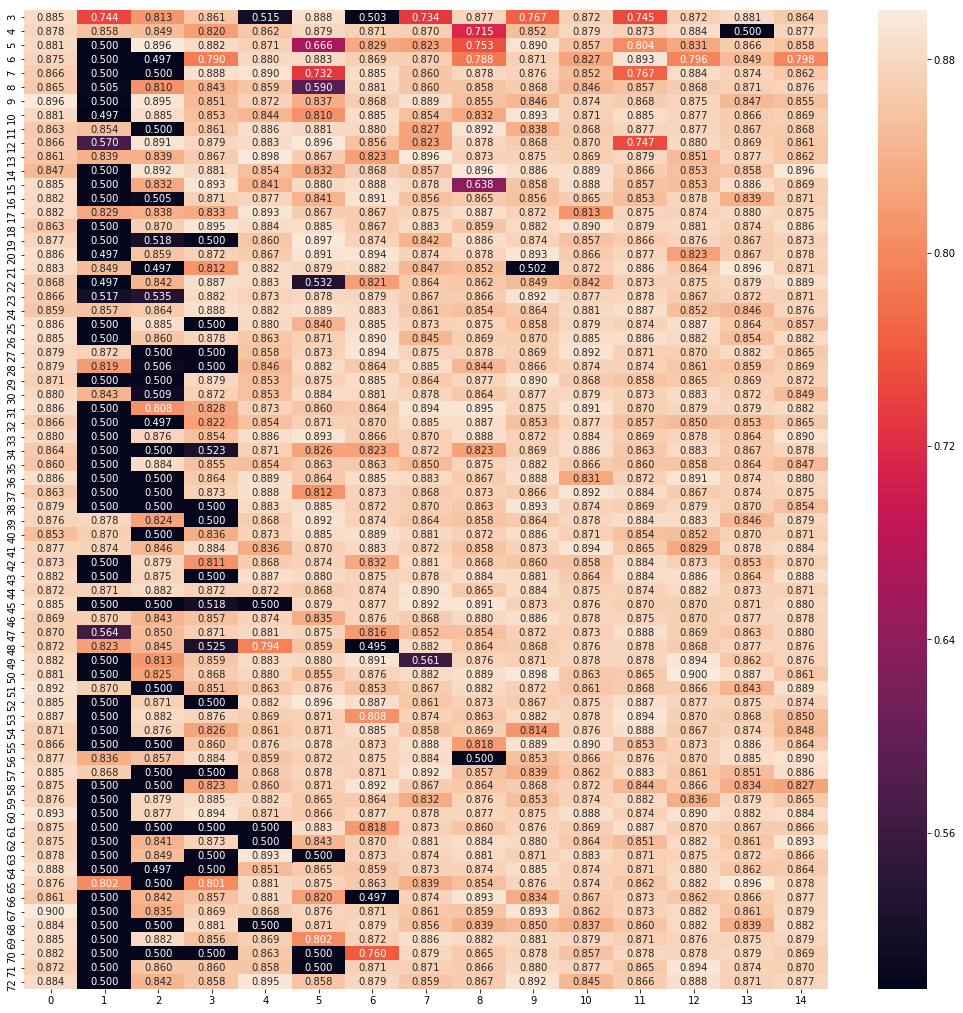

In [8]:
# The commented out sections were used for the real calculation of the neural networks AUC.

rand_dict = pickle.load(open('rand_dict', 'rb'))

def auc_score(values):  
    '''
    model = Sequential()
    model.add(Dense(values[0],activation='relu',input_shape=(19,)))
    if values[1] > 0:
        model.add(Dense(values[1],activation='relu'))
    model.add(Dense(2,activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    callbacks = [EarlyStopping(monitor='loss', min_delta=0, patience=2, mode='auto')]
    model.fit(X_train,y_train_cat,callbacks=callbacks,epochs=100,verbose=0)
    y_prediction = model.predict(X_test)
    return roc_auc_score(y_test_cat,y_prediction)
    '''
    return rand_dict['|'.join(list(map(lambda x: str(x),values)))]

'''
rand_dict = dict()
for i in range(3,73):
    for j in range(0,15):
        values = [i,j]
        print('Now running: {0}'.format(values))
        auc = auc_score(values)
        key = '{0}|{1}'.format(i,j)
        rand_dict[key] = auc
'''
aucs = pd.DataFrame(columns=list(range(0,15)),index=list(range(3,73)))
for k in rand_dict.keys():
    a = list(map(lambda x: int(x), k.split('|')))
    aucs.loc[a[0],a[1]]=rand_dict[k]
aucs = aucs[aucs.columns].astype(float)
plt.figure(figsize=(18,18))
sns.heatmap(aucs, annot=True, fmt='.3f')
plt.show()

In [9]:
top_nn = sorted(rand_dict, key=rand_dict.__getitem__, reverse=True)
print('Top architectures by AUC:')
for i in range(0,10):
    print(i+1,':',top_nn[i],'- AUC:',rand_dict[top_nn[i]])

Top architectures by AUC:
1 : 50|12 - AUC: 0.900212314225053
2 : 67|0 - AUC: 0.9000401675560912
3 : 50|9 - AUC: 0.8984334653124463
4 : 13|4 - AUC: 0.8982613186434842
5 : 19|5 - AUC: 0.8973432030756872
6 : 14|14 - AUC: 0.8964824697308773
7 : 12|5 - AUC: 0.8964250875078901
8 : 65|13 - AUC: 0.8963103230619154
9 : 5|2 - AUC: 0.8960807941699661
10 : 52|5 - AUC: 0.8960807941699661


## Genetic Models
The functions below will be used to evaluate the Genetic Models. `strength_function` will be used by the model to evaluate how strong is each solution. The function used here ensures that even the smallest step towards $AUC = 1.0$ will have a major impact. Finally, `create_chromosome` will be used to create random subjects in the population the model will examine.

In [10]:
def strength_function(values):
    auc = auc_score(values)
    if auc == 1.0:
        return math.inf
    else:
        return 1.0/(1.0-auc)**2
    
def create_chromosome():
    return [random.randint(3,72),random.randint(0,14)]

The model will run 5 times and the scores will be averaged:

In [11]:
values = {0: list(range(3,73)), 1: list(range(0,15))}
gm_avg = 0
for i in range(0,5):
    pred_dict = dict()
    population = list()
    for _ in range(0,8):
        population.append(create_chromosome())
    gmodel = pycharles.Model(population, values, strength_function, seed=SEED, early_stop=2)
    gmodel.evolve()
    score = auc_score(gmodel.get_best())
    print('AUC',i+1,':',gmodel.get_best(),', AUC:',score,', No. of generations:',gmodel.get_current_generation())
    gm_avg += score
gm_avg /= 5
print('Genetic model average AUC:',gm_avg)

AUC 1 : [57, 0] , AUC: 0.8848912606874391 , No. of generations: 2
AUC 2 : [15, 3] , AUC: 0.892810007459689 , No. of generations: 4
AUC 3 : [12, 2] , AUC: 0.8913467607735124 , No. of generations: 3
AUC 4 : [9, 2] , AUC: 0.8945314741493084 , No. of generations: 4
AUC 5 : [12, 2] , AUC: 0.8913467607735124 , No. of generations: 3
Genetic model average AUC: 0.8909852527686922


Let's check how many solutions in the solution-space exists which are better than the average AUC score found by the model:

In [12]:
s = 0
for k in rand_dict.keys():
    if rand_dict[k] >= gm_avg:
        s += 1
print(s,s/len(rand_dict))

54 0.05142857142857143


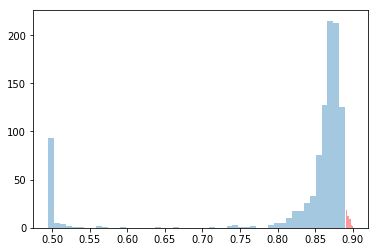

In [13]:
lower = list()
greater = list()
rounded_gm = round(gm_avg,3)
for k in rand_dict.keys():
    v = round(rand_dict[k],3)
    if v < rounded_gm:
        lower.append(v)
    else:
        greater.append(v)
sns.distplot(lower,kde=False)
sns.distplot(greater,kde=False,color='r')
plt.show()

The model's population consisted of 8 subjects, which evolved for an average of 3 generations. For every generation, 7 new solutions were created (the top solution advances to the next generation as-is). That means that the model had to compute $8+7*3=29$ neural networks before stopping at a local maximum. 
Let's now calculate how many random solutions we need to try in order to get an equal or better solution than that of the model with good probability. This is given by:
$$p=1-\left(\frac{1050-54}{1050}\right)^n$$
where $n$ is the number attempts

In [14]:
@interact(p = (0.0,1.0), n =(0,100))
def plot_np(n=30,p=0.9):
    eq_y = parse_expr('p')
    eq_x = parse_expr('1-(({all}-{greater})/{all})**n'.format(all=len(rand_dict),greater=len(greater)))
    plot_implicit(eq_y-eq_x,x_var=('n',0,n),y_var=('p',0,p))

interactive(children=(IntSlider(value=30, description='n'), FloatSlider(value=0.9, description='p', max=1.0), Output()), _dom_classes=('widget-interact',))

In [15]:
print('p(n=29) = {p:.3f}'.format(p=1-((len(rand_dict)-len(greater))/len(rand_dict))**29))

p(n=29) = 0.796


We see that after 29 random attempts (which is the number of solutions the model scanned), there's a 80% chance of getting an equal or better solution than the one we got from the model. So it seems as Genetic Models are just as good as random selections..